# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:17, 10.6MB/s]                              
SVHN Testing Set: 64.3MB [00:07, 8.76MB/s]                              


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

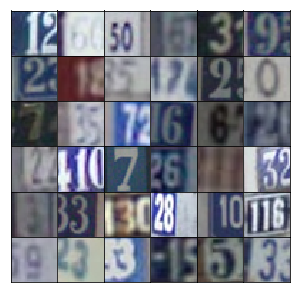

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
# alpha is parameter for leaky ReLU
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(x1 * alpha, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(x2 * alpha, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(x3 * alpha, x3)
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(x1 * alpha, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2 * alpha, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3 * alpha, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [19]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 5
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/5... Discriminator Loss: 0.8682... Generator Loss: 1.1001
Epoch 1/5... Discriminator Loss: 0.3326... Generator Loss: 2.2077
Epoch 1/5... Discriminator Loss: 0.1349... Generator Loss: 2.7016
Epoch 1/5... Discriminator Loss: 0.1271... Generator Loss: 4.8935
Epoch 1/5... Discriminator Loss: 0.1396... Generator Loss: 4.7472
Epoch 1/5... Discriminator Loss: 0.1083... Generator Loss: 2.8831
Epoch 1/5... Discriminator Loss: 0.1499... Generator Loss: 2.5366
Epoch 1/5... Discriminator Loss: 0.1655... Generator Loss: 3.8068
Epoch 1/5... Discriminator Loss: 0.1420... Generator Loss: 3.8051
Epoch 1/5... Discriminator Loss: 1.0728... Generator Loss: 3.3468


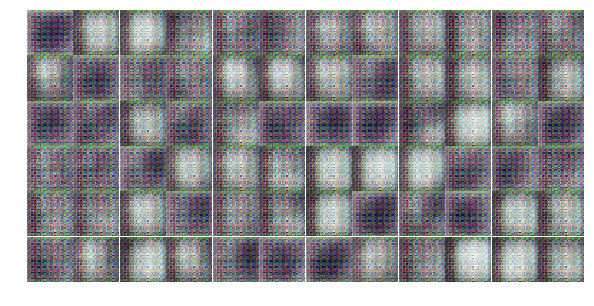

Epoch 1/5... Discriminator Loss: 0.5856... Generator Loss: 1.6498
Epoch 1/5... Discriminator Loss: 0.3318... Generator Loss: 2.1392
Epoch 1/5... Discriminator Loss: 0.3556... Generator Loss: 1.8569
Epoch 1/5... Discriminator Loss: 0.2382... Generator Loss: 2.0561
Epoch 1/5... Discriminator Loss: 0.8838... Generator Loss: 0.8050
Epoch 1/5... Discriminator Loss: 0.2947... Generator Loss: 2.0515
Epoch 1/5... Discriminator Loss: 0.1550... Generator Loss: 3.3071
Epoch 1/5... Discriminator Loss: 1.1924... Generator Loss: 1.0780
Epoch 1/5... Discriminator Loss: 0.4279... Generator Loss: 2.5170
Epoch 1/5... Discriminator Loss: 0.1046... Generator Loss: 3.5864


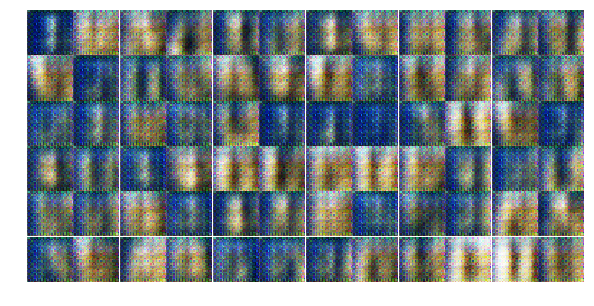

Epoch 1/5... Discriminator Loss: 0.2157... Generator Loss: 2.9046
Epoch 1/5... Discriminator Loss: 0.7783... Generator Loss: 3.1334
Epoch 1/5... Discriminator Loss: 0.2893... Generator Loss: 1.9594
Epoch 1/5... Discriminator Loss: 0.4323... Generator Loss: 1.3387
Epoch 1/5... Discriminator Loss: 0.8138... Generator Loss: 4.7254
Epoch 1/5... Discriminator Loss: 0.3208... Generator Loss: 2.5973
Epoch 1/5... Discriminator Loss: 0.5272... Generator Loss: 1.2367
Epoch 1/5... Discriminator Loss: 0.7321... Generator Loss: 3.6897
Epoch 1/5... Discriminator Loss: 0.8848... Generator Loss: 4.7132
Epoch 1/5... Discriminator Loss: 0.2452... Generator Loss: 4.0939


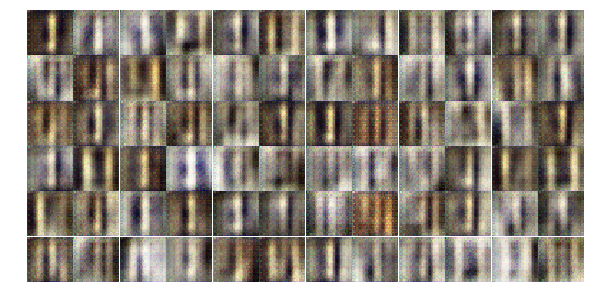

Epoch 1/5... Discriminator Loss: 0.8788... Generator Loss: 0.8390
Epoch 1/5... Discriminator Loss: 0.3577... Generator Loss: 2.5612
Epoch 1/5... Discriminator Loss: 0.1549... Generator Loss: 3.1538
Epoch 1/5... Discriminator Loss: 0.2007... Generator Loss: 2.5140
Epoch 1/5... Discriminator Loss: 0.1878... Generator Loss: 3.5873
Epoch 1/5... Discriminator Loss: 0.1376... Generator Loss: 2.9371
Epoch 1/5... Discriminator Loss: 0.3286... Generator Loss: 1.6499
Epoch 1/5... Discriminator Loss: 0.3267... Generator Loss: 5.1469
Epoch 1/5... Discriminator Loss: 0.1869... Generator Loss: 4.8626
Epoch 1/5... Discriminator Loss: 0.1477... Generator Loss: 2.7554


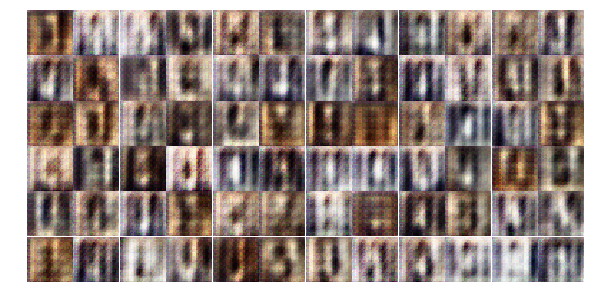

Epoch 1/5... Discriminator Loss: 2.3325... Generator Loss: 0.2129
Epoch 1/5... Discriminator Loss: 1.0773... Generator Loss: 1.0179
Epoch 1/5... Discriminator Loss: 0.9833... Generator Loss: 0.8062
Epoch 1/5... Discriminator Loss: 0.8973... Generator Loss: 3.7748
Epoch 1/5... Discriminator Loss: 0.6194... Generator Loss: 1.4968
Epoch 1/5... Discriminator Loss: 0.6714... Generator Loss: 1.2659
Epoch 1/5... Discriminator Loss: 0.9210... Generator Loss: 1.1875
Epoch 1/5... Discriminator Loss: 0.6048... Generator Loss: 1.7378
Epoch 1/5... Discriminator Loss: 0.6166... Generator Loss: 1.3857
Epoch 1/5... Discriminator Loss: 0.5752... Generator Loss: 1.6900


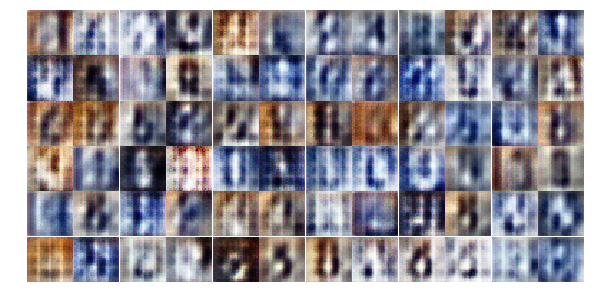

Epoch 1/5... Discriminator Loss: 0.5477... Generator Loss: 1.5961
Epoch 1/5... Discriminator Loss: 0.5464... Generator Loss: 1.4959
Epoch 1/5... Discriminator Loss: 0.6417... Generator Loss: 1.3894
Epoch 1/5... Discriminator Loss: 0.7087... Generator Loss: 1.1127
Epoch 1/5... Discriminator Loss: 1.2836... Generator Loss: 0.5327
Epoch 1/5... Discriminator Loss: 0.4928... Generator Loss: 1.7596
Epoch 1/5... Discriminator Loss: 0.6397... Generator Loss: 1.5369
Epoch 2/5... Discriminator Loss: 0.9123... Generator Loss: 1.3304
Epoch 2/5... Discriminator Loss: 0.5744... Generator Loss: 1.7550
Epoch 2/5... Discriminator Loss: 0.8086... Generator Loss: 1.2621


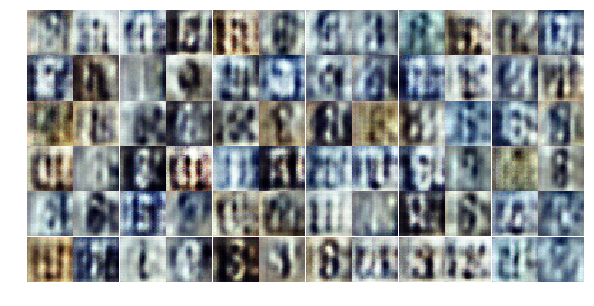

Epoch 2/5... Discriminator Loss: 0.7230... Generator Loss: 1.2652
Epoch 2/5... Discriminator Loss: 0.8498... Generator Loss: 1.5629
Epoch 2/5... Discriminator Loss: 0.8525... Generator Loss: 1.1168
Epoch 2/5... Discriminator Loss: 1.2832... Generator Loss: 2.2767
Epoch 2/5... Discriminator Loss: 1.3452... Generator Loss: 0.7854
Epoch 2/5... Discriminator Loss: 0.7873... Generator Loss: 1.0844
Epoch 2/5... Discriminator Loss: 0.8761... Generator Loss: 0.8930
Epoch 2/5... Discriminator Loss: 1.1625... Generator Loss: 0.9520
Epoch 2/5... Discriminator Loss: 1.0467... Generator Loss: 0.9186
Epoch 2/5... Discriminator Loss: 0.9040... Generator Loss: 1.1136


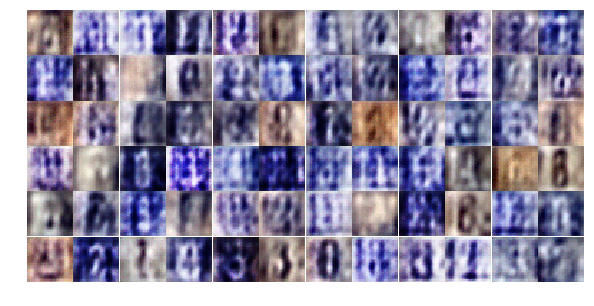

Epoch 2/5... Discriminator Loss: 1.2796... Generator Loss: 1.8815
Epoch 2/5... Discriminator Loss: 0.8596... Generator Loss: 1.5177
Epoch 2/5... Discriminator Loss: 0.8775... Generator Loss: 1.1525
Epoch 2/5... Discriminator Loss: 0.8387... Generator Loss: 1.4194
Epoch 2/5... Discriminator Loss: 0.6946... Generator Loss: 1.5269
Epoch 2/5... Discriminator Loss: 0.7807... Generator Loss: 1.2204
Epoch 2/5... Discriminator Loss: 0.9517... Generator Loss: 1.2576
Epoch 2/5... Discriminator Loss: 0.8664... Generator Loss: 0.9141
Epoch 2/5... Discriminator Loss: 1.1380... Generator Loss: 0.7130
Epoch 2/5... Discriminator Loss: 0.7884... Generator Loss: 1.1168


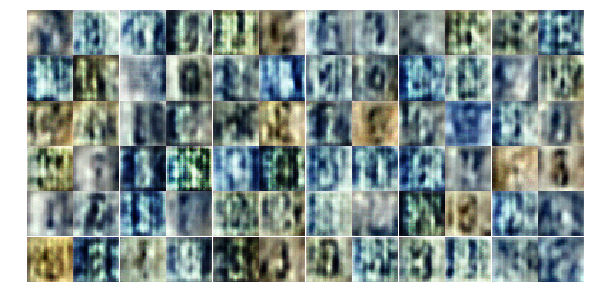

Epoch 2/5... Discriminator Loss: 0.9625... Generator Loss: 1.1080
Epoch 2/5... Discriminator Loss: 1.2445... Generator Loss: 1.7975
Epoch 2/5... Discriminator Loss: 0.9057... Generator Loss: 1.2593
Epoch 2/5... Discriminator Loss: 0.6788... Generator Loss: 1.1439
Epoch 2/5... Discriminator Loss: 0.7371... Generator Loss: 1.6497
Epoch 2/5... Discriminator Loss: 0.7148... Generator Loss: 1.2624
Epoch 2/5... Discriminator Loss: 0.8991... Generator Loss: 1.1660
Epoch 2/5... Discriminator Loss: 1.0312... Generator Loss: 0.8346
Epoch 2/5... Discriminator Loss: 1.1536... Generator Loss: 0.9161
Epoch 2/5... Discriminator Loss: 0.8308... Generator Loss: 1.2323


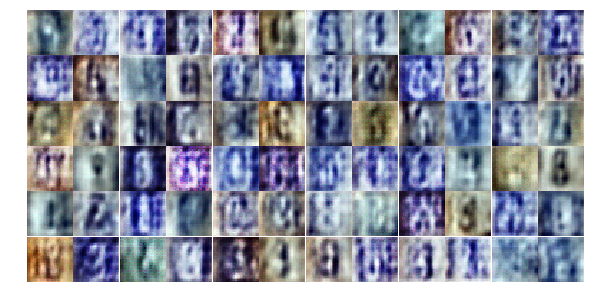

Epoch 2/5... Discriminator Loss: 1.1146... Generator Loss: 1.3254
Epoch 2/5... Discriminator Loss: 0.8670... Generator Loss: 1.3114
Epoch 2/5... Discriminator Loss: 1.0610... Generator Loss: 0.8844
Epoch 2/5... Discriminator Loss: 1.3904... Generator Loss: 0.6934
Epoch 2/5... Discriminator Loss: 0.9046... Generator Loss: 1.6011
Epoch 2/5... Discriminator Loss: 1.0406... Generator Loss: 0.8811
Epoch 2/5... Discriminator Loss: 1.0036... Generator Loss: 1.2765
Epoch 2/5... Discriminator Loss: 0.9189... Generator Loss: 1.6928
Epoch 2/5... Discriminator Loss: 1.0023... Generator Loss: 1.0735
Epoch 2/5... Discriminator Loss: 0.7550... Generator Loss: 1.1940


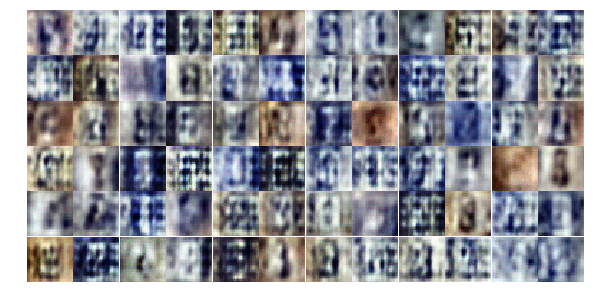

Epoch 2/5... Discriminator Loss: 0.8514... Generator Loss: 0.9973
Epoch 2/5... Discriminator Loss: 0.8430... Generator Loss: 1.0784
Epoch 2/5... Discriminator Loss: 0.8336... Generator Loss: 1.1976
Epoch 2/5... Discriminator Loss: 1.0616... Generator Loss: 0.7688
Epoch 2/5... Discriminator Loss: 0.8502... Generator Loss: 1.1354
Epoch 2/5... Discriminator Loss: 1.0335... Generator Loss: 0.9150
Epoch 2/5... Discriminator Loss: 1.2191... Generator Loss: 2.1802
Epoch 2/5... Discriminator Loss: 0.8797... Generator Loss: 1.6513
Epoch 2/5... Discriminator Loss: 0.5610... Generator Loss: 1.6814
Epoch 2/5... Discriminator Loss: 0.6877... Generator Loss: 1.5509


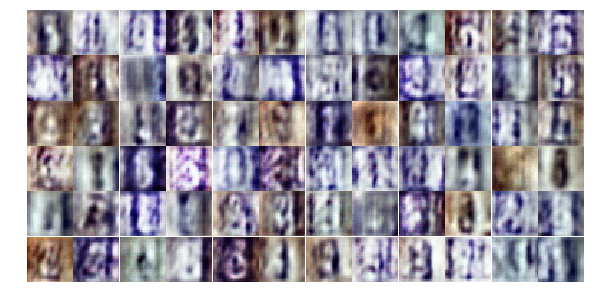

Epoch 2/5... Discriminator Loss: 0.9750... Generator Loss: 1.2086
Epoch 2/5... Discriminator Loss: 0.8970... Generator Loss: 0.9374
Epoch 2/5... Discriminator Loss: 1.0069... Generator Loss: 0.9217
Epoch 2/5... Discriminator Loss: 0.7879... Generator Loss: 1.2564
Epoch 3/5... Discriminator Loss: 0.7573... Generator Loss: 2.4464
Epoch 3/5... Discriminator Loss: 0.6274... Generator Loss: 1.2614
Epoch 3/5... Discriminator Loss: 0.8127... Generator Loss: 2.1890
Epoch 3/5... Discriminator Loss: 0.5806... Generator Loss: 1.5650
Epoch 3/5... Discriminator Loss: 0.7653... Generator Loss: 1.1944
Epoch 3/5... Discriminator Loss: 0.6470... Generator Loss: 1.3871


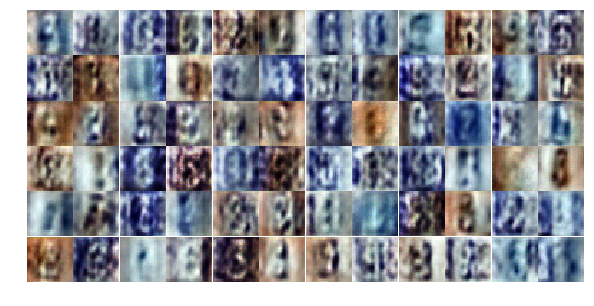

Epoch 3/5... Discriminator Loss: 0.7560... Generator Loss: 1.1451
Epoch 3/5... Discriminator Loss: 0.5983... Generator Loss: 1.8275
Epoch 3/5... Discriminator Loss: 0.9193... Generator Loss: 0.8200
Epoch 3/5... Discriminator Loss: 0.8890... Generator Loss: 1.3450
Epoch 3/5... Discriminator Loss: 0.9683... Generator Loss: 0.8791
Epoch 3/5... Discriminator Loss: 0.7568... Generator Loss: 0.9548
Epoch 3/5... Discriminator Loss: 0.8265... Generator Loss: 1.1795
Epoch 3/5... Discriminator Loss: 0.6309... Generator Loss: 1.2314
Epoch 3/5... Discriminator Loss: 0.6288... Generator Loss: 1.8402
Epoch 3/5... Discriminator Loss: 0.6741... Generator Loss: 1.4889


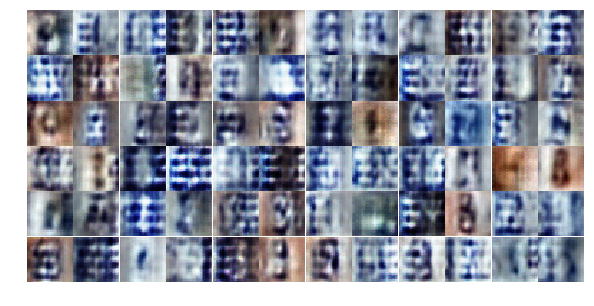

Epoch 3/5... Discriminator Loss: 0.5785... Generator Loss: 1.7803
Epoch 3/5... Discriminator Loss: 0.8279... Generator Loss: 1.2977
Epoch 3/5... Discriminator Loss: 0.8784... Generator Loss: 1.0621
Epoch 3/5... Discriminator Loss: 0.5694... Generator Loss: 1.5085
Epoch 3/5... Discriminator Loss: 1.3015... Generator Loss: 0.5110
Epoch 3/5... Discriminator Loss: 0.5631... Generator Loss: 1.7585
Epoch 3/5... Discriminator Loss: 0.8036... Generator Loss: 0.8970
Epoch 3/5... Discriminator Loss: 0.5113... Generator Loss: 1.6490
Epoch 3/5... Discriminator Loss: 0.8630... Generator Loss: 0.8554
Epoch 3/5... Discriminator Loss: 0.4925... Generator Loss: 1.5561


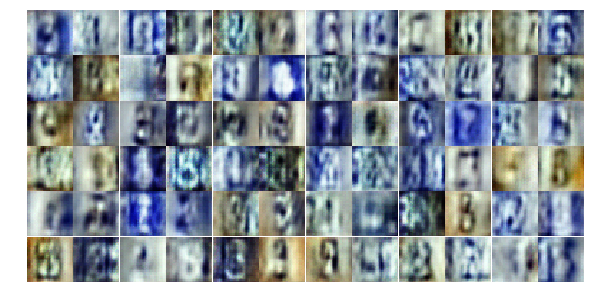

Epoch 3/5... Discriminator Loss: 0.5760... Generator Loss: 2.3544
Epoch 3/5... Discriminator Loss: 0.6252... Generator Loss: 1.3312
Epoch 3/5... Discriminator Loss: 0.5298... Generator Loss: 1.5808
Epoch 3/5... Discriminator Loss: 0.7633... Generator Loss: 0.8608
Epoch 3/5... Discriminator Loss: 0.5244... Generator Loss: 1.8232
Epoch 3/5... Discriminator Loss: 0.5218... Generator Loss: 1.8205
Epoch 3/5... Discriminator Loss: 1.6982... Generator Loss: 0.3330
Epoch 3/5... Discriminator Loss: 0.6110... Generator Loss: 1.3793
Epoch 3/5... Discriminator Loss: 0.7617... Generator Loss: 1.1706
Epoch 3/5... Discriminator Loss: 0.4077... Generator Loss: 1.9174


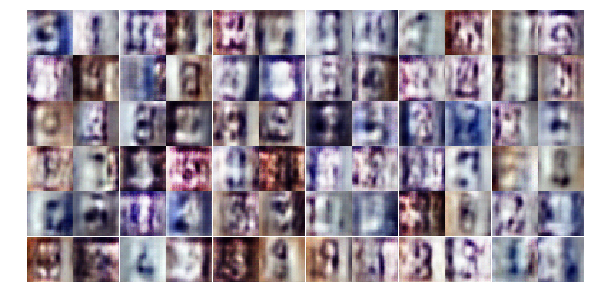

Epoch 3/5... Discriminator Loss: 0.4215... Generator Loss: 1.9609
Epoch 3/5... Discriminator Loss: 0.3352... Generator Loss: 1.8641
Epoch 3/5... Discriminator Loss: 0.5013... Generator Loss: 1.5819
Epoch 3/5... Discriminator Loss: 0.5394... Generator Loss: 1.4836
Epoch 3/5... Discriminator Loss: 0.5470... Generator Loss: 2.7999
Epoch 3/5... Discriminator Loss: 0.3798... Generator Loss: 1.7794
Epoch 3/5... Discriminator Loss: 0.4414... Generator Loss: 2.4737
Epoch 3/5... Discriminator Loss: 0.3935... Generator Loss: 1.8366
Epoch 3/5... Discriminator Loss: 0.9873... Generator Loss: 2.4692
Epoch 3/5... Discriminator Loss: 0.8421... Generator Loss: 1.4952


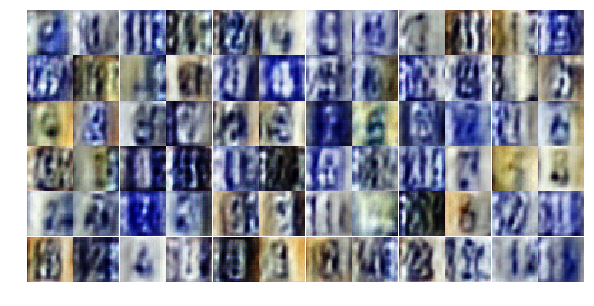

Epoch 3/5... Discriminator Loss: 0.7224... Generator Loss: 1.8841
Epoch 3/5... Discriminator Loss: 0.7512... Generator Loss: 1.2184
Epoch 3/5... Discriminator Loss: 0.6317... Generator Loss: 1.2547
Epoch 3/5... Discriminator Loss: 0.3358... Generator Loss: 2.0614
Epoch 3/5... Discriminator Loss: 0.2784... Generator Loss: 2.9195
Epoch 3/5... Discriminator Loss: 0.3235... Generator Loss: 2.1209
Epoch 3/5... Discriminator Loss: 0.5275... Generator Loss: 2.4171
Epoch 3/5... Discriminator Loss: 0.4393... Generator Loss: 1.7315
Epoch 3/5... Discriminator Loss: 0.5688... Generator Loss: 1.9513
Epoch 3/5... Discriminator Loss: 0.6567... Generator Loss: 1.1778


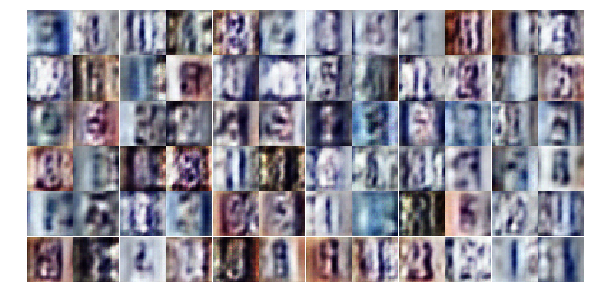

Epoch 3/5... Discriminator Loss: 0.6910... Generator Loss: 1.4107
Epoch 4/5... Discriminator Loss: 0.7043... Generator Loss: 1.4564
Epoch 4/5... Discriminator Loss: 0.4613... Generator Loss: 2.3173
Epoch 4/5... Discriminator Loss: 1.0088... Generator Loss: 0.8251
Epoch 4/5... Discriminator Loss: 0.5073... Generator Loss: 1.8871
Epoch 4/5... Discriminator Loss: 0.7253... Generator Loss: 1.0085
Epoch 4/5... Discriminator Loss: 0.4518... Generator Loss: 1.5792
Epoch 4/5... Discriminator Loss: 0.9476... Generator Loss: 0.7241
Epoch 4/5... Discriminator Loss: 0.3421... Generator Loss: 1.8621
Epoch 4/5... Discriminator Loss: 0.3643... Generator Loss: 1.9781


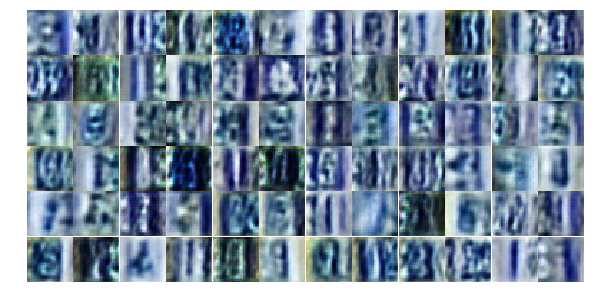

Epoch 4/5... Discriminator Loss: 0.3868... Generator Loss: 1.7593
Epoch 4/5... Discriminator Loss: 0.4817... Generator Loss: 1.3080
Epoch 4/5... Discriminator Loss: 0.5569... Generator Loss: 1.3037
Epoch 4/5... Discriminator Loss: 0.9549... Generator Loss: 0.7973
Epoch 4/5... Discriminator Loss: 1.4830... Generator Loss: 0.3661
Epoch 4/5... Discriminator Loss: 1.8772... Generator Loss: 0.2371
Epoch 4/5... Discriminator Loss: 0.6512... Generator Loss: 1.2382
Epoch 4/5... Discriminator Loss: 0.4583... Generator Loss: 1.5113
Epoch 4/5... Discriminator Loss: 0.6548... Generator Loss: 1.3895
Epoch 4/5... Discriminator Loss: 0.6094... Generator Loss: 1.5519


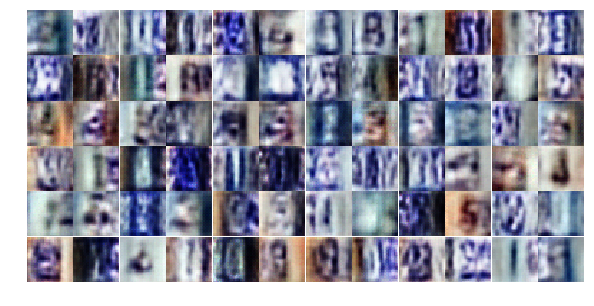

Epoch 4/5... Discriminator Loss: 0.5402... Generator Loss: 1.3035
Epoch 4/5... Discriminator Loss: 0.3670... Generator Loss: 2.6380
Epoch 4/5... Discriminator Loss: 0.5443... Generator Loss: 1.5632
Epoch 4/5... Discriminator Loss: 0.3508... Generator Loss: 2.0968
Epoch 4/5... Discriminator Loss: 0.4537... Generator Loss: 1.4791
Epoch 4/5... Discriminator Loss: 0.6522... Generator Loss: 3.1145
Epoch 4/5... Discriminator Loss: 0.8278... Generator Loss: 0.7992
Epoch 4/5... Discriminator Loss: 1.4785... Generator Loss: 0.3899
Epoch 4/5... Discriminator Loss: 1.1116... Generator Loss: 3.6765
Epoch 4/5... Discriminator Loss: 0.4593... Generator Loss: 2.3658


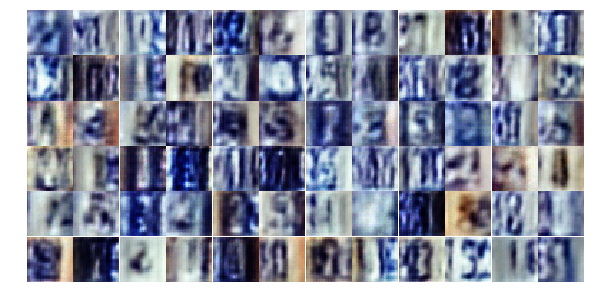

Epoch 4/5... Discriminator Loss: 0.4029... Generator Loss: 1.8641
Epoch 4/5... Discriminator Loss: 0.4506... Generator Loss: 1.5337
Epoch 4/5... Discriminator Loss: 0.3341... Generator Loss: 2.0150
Epoch 4/5... Discriminator Loss: 0.3690... Generator Loss: 3.4389
Epoch 4/5... Discriminator Loss: 0.3092... Generator Loss: 2.3501
Epoch 4/5... Discriminator Loss: 0.3767... Generator Loss: 2.7664
Epoch 4/5... Discriminator Loss: 0.7143... Generator Loss: 1.0240
Epoch 4/5... Discriminator Loss: 0.4863... Generator Loss: 2.1151
Epoch 4/5... Discriminator Loss: 0.5355... Generator Loss: 1.4631
Epoch 4/5... Discriminator Loss: 0.3841... Generator Loss: 1.6609


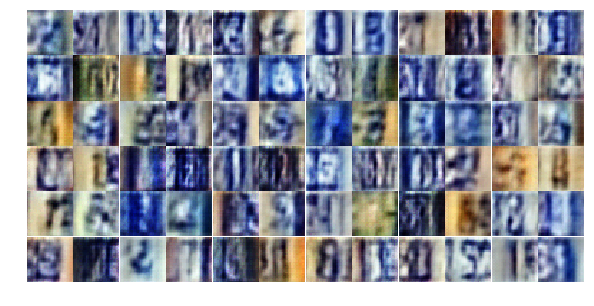

Epoch 4/5... Discriminator Loss: 0.7253... Generator Loss: 0.9146
Epoch 4/5... Discriminator Loss: 0.8306... Generator Loss: 0.8630
Epoch 4/5... Discriminator Loss: 0.4312... Generator Loss: 1.6710
Epoch 4/5... Discriminator Loss: 0.6714... Generator Loss: 2.4458
Epoch 4/5... Discriminator Loss: 0.2813... Generator Loss: 2.3621
Epoch 4/5... Discriminator Loss: 1.4932... Generator Loss: 0.3780
Epoch 4/5... Discriminator Loss: 0.8884... Generator Loss: 3.0187
Epoch 4/5... Discriminator Loss: 0.4152... Generator Loss: 1.8435
Epoch 4/5... Discriminator Loss: 1.0432... Generator Loss: 0.6337
Epoch 4/5... Discriminator Loss: 0.3633... Generator Loss: 1.8302


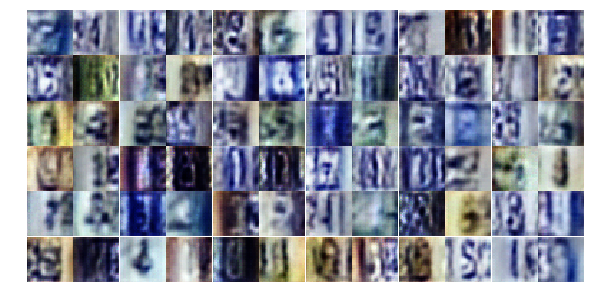

Epoch 4/5... Discriminator Loss: 0.2964... Generator Loss: 2.2769
Epoch 4/5... Discriminator Loss: 0.4794... Generator Loss: 2.3121
Epoch 4/5... Discriminator Loss: 0.2147... Generator Loss: 2.4833
Epoch 4/5... Discriminator Loss: 0.6271... Generator Loss: 2.2144
Epoch 4/5... Discriminator Loss: 0.4132... Generator Loss: 2.4151
Epoch 4/5... Discriminator Loss: 0.4349... Generator Loss: 2.2689
Epoch 4/5... Discriminator Loss: 0.3775... Generator Loss: 1.5765
Epoch 4/5... Discriminator Loss: 0.7535... Generator Loss: 2.6631
Epoch 4/5... Discriminator Loss: 0.4446... Generator Loss: 1.9785
Epoch 5/5... Discriminator Loss: 0.5278... Generator Loss: 1.2324


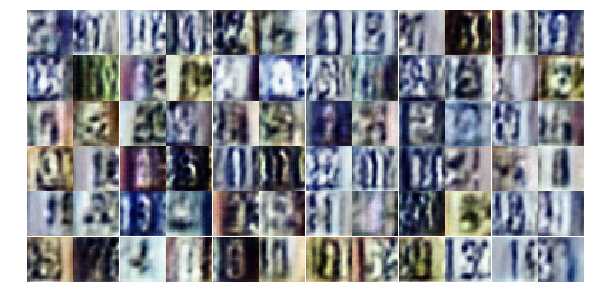

Epoch 5/5... Discriminator Loss: 0.3607... Generator Loss: 1.6879
Epoch 5/5... Discriminator Loss: 0.3968... Generator Loss: 1.6367
Epoch 5/5... Discriminator Loss: 0.4866... Generator Loss: 1.3138
Epoch 5/5... Discriminator Loss: 0.4795... Generator Loss: 1.3297
Epoch 5/5... Discriminator Loss: 1.2017... Generator Loss: 3.9390
Epoch 5/5... Discriminator Loss: 0.9739... Generator Loss: 0.7255
Epoch 5/5... Discriminator Loss: 0.3974... Generator Loss: 1.8482
Epoch 5/5... Discriminator Loss: 0.5537... Generator Loss: 1.3042
Epoch 5/5... Discriminator Loss: 0.5620... Generator Loss: 1.2755
Epoch 5/5... Discriminator Loss: 0.4845... Generator Loss: 1.5103


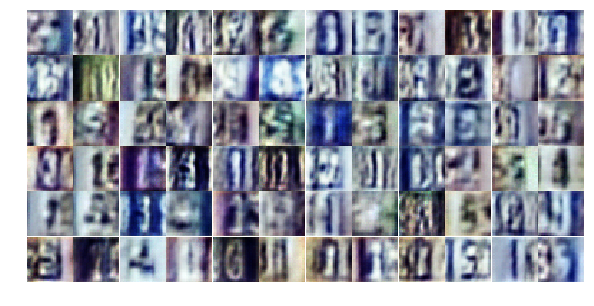

Epoch 5/5... Discriminator Loss: 0.4007... Generator Loss: 1.5949
Epoch 5/5... Discriminator Loss: 0.4796... Generator Loss: 1.3380
Epoch 5/5... Discriminator Loss: 0.3733... Generator Loss: 2.1318
Epoch 5/5... Discriminator Loss: 1.5332... Generator Loss: 0.4533
Epoch 5/5... Discriminator Loss: 0.8493... Generator Loss: 1.8267
Epoch 5/5... Discriminator Loss: 0.5430... Generator Loss: 1.3302
Epoch 5/5... Discriminator Loss: 0.5003... Generator Loss: 1.2727
Epoch 5/5... Discriminator Loss: 0.5234... Generator Loss: 1.2917
Epoch 5/5... Discriminator Loss: 0.3617... Generator Loss: 1.8244
Epoch 5/5... Discriminator Loss: 0.8339... Generator Loss: 0.8408


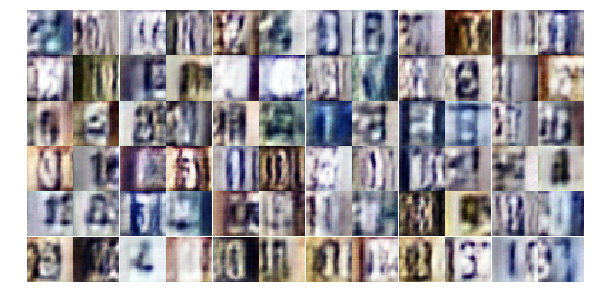

Epoch 5/5... Discriminator Loss: 0.3776... Generator Loss: 2.2713
Epoch 5/5... Discriminator Loss: 1.5449... Generator Loss: 0.3381
Epoch 5/5... Discriminator Loss: 0.6204... Generator Loss: 1.8572
Epoch 5/5... Discriminator Loss: 0.5291... Generator Loss: 1.5924
Epoch 5/5... Discriminator Loss: 0.6766... Generator Loss: 1.1125
Epoch 5/5... Discriminator Loss: 0.6449... Generator Loss: 1.0338
Epoch 5/5... Discriminator Loss: 1.1708... Generator Loss: 0.5237
Epoch 5/5... Discriminator Loss: 0.4463... Generator Loss: 2.2393
Epoch 5/5... Discriminator Loss: 0.5954... Generator Loss: 1.5544
Epoch 5/5... Discriminator Loss: 0.2461... Generator Loss: 2.2164


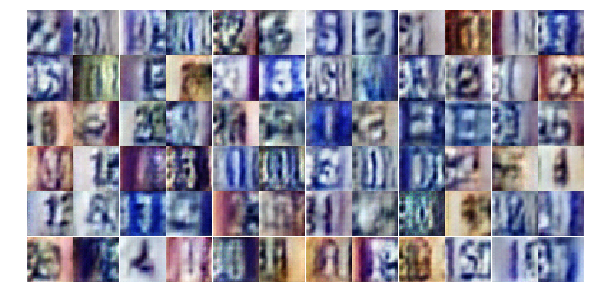

Epoch 5/5... Discriminator Loss: 0.6130... Generator Loss: 3.1262
Epoch 5/5... Discriminator Loss: 0.3646... Generator Loss: 1.8615
Epoch 5/5... Discriminator Loss: 0.2863... Generator Loss: 2.0135
Epoch 5/5... Discriminator Loss: 0.3707... Generator Loss: 1.9301
Epoch 5/5... Discriminator Loss: 0.3493... Generator Loss: 1.9291
Epoch 5/5... Discriminator Loss: 0.6863... Generator Loss: 1.8098
Epoch 5/5... Discriminator Loss: 0.8962... Generator Loss: 0.8132
Epoch 5/5... Discriminator Loss: 0.7574... Generator Loss: 1.0590
Epoch 5/5... Discriminator Loss: 0.7930... Generator Loss: 1.0065
Epoch 5/5... Discriminator Loss: 0.4656... Generator Loss: 1.5490


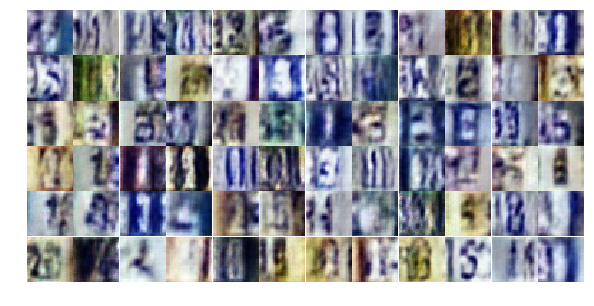

Epoch 5/5... Discriminator Loss: 0.2777... Generator Loss: 2.2957
Epoch 5/5... Discriminator Loss: 0.6601... Generator Loss: 1.0449
Epoch 5/5... Discriminator Loss: 1.1899... Generator Loss: 0.4986
Epoch 5/5... Discriminator Loss: 0.4403... Generator Loss: 2.4261
Epoch 5/5... Discriminator Loss: 0.7795... Generator Loss: 1.1986
Epoch 5/5... Discriminator Loss: 0.9322... Generator Loss: 0.6364
Epoch 5/5... Discriminator Loss: 0.9410... Generator Loss: 2.6149
Epoch 5/5... Discriminator Loss: 0.6187... Generator Loss: 1.3023
Epoch 5/5... Discriminator Loss: 0.6119... Generator Loss: 1.1219
Epoch 5/5... Discriminator Loss: 0.3823... Generator Loss: 1.8385


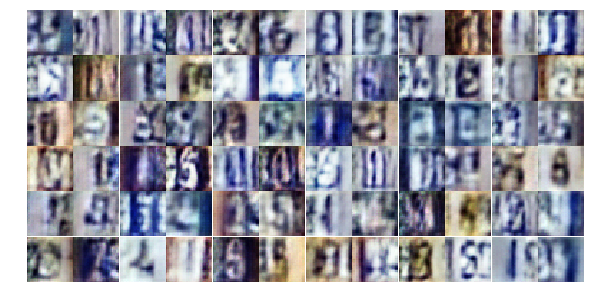

Epoch 5/5... Discriminator Loss: 0.7943... Generator Loss: 0.8142
Epoch 5/5... Discriminator Loss: 0.6305... Generator Loss: 1.0793
Epoch 5/5... Discriminator Loss: 0.6757... Generator Loss: 2.1429
Epoch 5/5... Discriminator Loss: 0.6736... Generator Loss: 1.0094
Epoch 5/5... Discriminator Loss: 1.0824... Generator Loss: 0.6007
Epoch 5/5... Discriminator Loss: 0.9904... Generator Loss: 0.6677


In [20]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

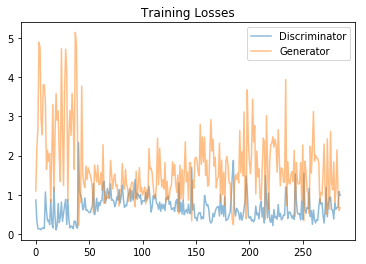

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

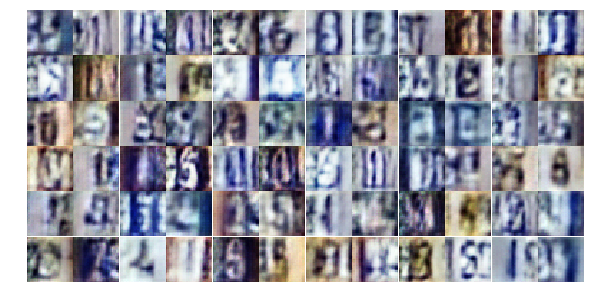

In [22]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))